+ ^RUT - US2000
+ ^GSPC - SP500
+ ^DJI - US30
+ ^IXIC - NASDAQ

In [1]:
%matplotlib inline

import os, time
os.environ['TZ'] = 'America/New_York'
time.tzset()

import logging
global logger
logger = logging.getLogger('nb')
logger.setLevel(logging.INFO)

import hashlib
import joblib
import json
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from IPython.display import display, HTML
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import hstack
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Make the graphs a bit prettier, and bigger
matplotlib.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
pd.set_option('display.min_rows', 40)

plt.rcParams['figure.figsize'] = (15, 5)

# read configuration
cfg = {}
config_file = os.path.join('cfg', 'lstm_online.json')
with open(config_file, mode='r') as fp:
    cfg = json.load(fp)
    
display(HTML('<h3>' + config_file + '</h3><pre>' + json.dumps(cfg, indent=4) + '</pre>'))

model_metadata = {
    'cfg': cfg
}

In [2]:
def tsg2tsv(tsg):
    ret = ''
    for i in range(len(tsg)):
        x, y = tsg[i]
        ret += '%s => %s\n' % (x, y)
    return ret

def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def normalize(data, columns):
    scalers = {}
    data_scaled = pd.DataFrame(index=data.index, columns=columns)
    for column in data_scaled.columns:
        logger.debug(column)
        scaler = MinMaxScaler(feature_range=(0,1))
        scalers[column]=scaler
        data_scaled[[column]] = scaler.fit_transform(data[[column]]).reshape(-1, 1)
    return data_scaled, scalers

def inverse_normalize(na, scalers:list) -> pd.DataFrame:
    index = na.index if isinstance(na, pd.DataFrame) else None
    df = pd.DataFrame(np.copy(na.values) if isinstance(na, pd.DataFrame) else na.copy(), columns=scalers.keys())
    for column,scaler in scalers.items():
        df[[column]] = scaler.inverse_transform(df[[column]]).reshape(-1, 1)
    if index is not None:
        df.set_index(index, inplace=True)
    return df

def transform(df, k=cfg['prediction_steps']):
    if cfg['differential'].lower() == 'true':
        logger.info('differential mode: transforming data...')
        if isinstance(df, pd.DataFrame):
            return df.diff(1, axis=0)[1:]
        else:
            return df[k:] - df[:-k]
    else:
        return df

def inverse_transform(pred, prev=None):
    if cfg['differential'].lower() == 'true':
        logger.info('differential mode')
        return prev + pred
    else:
        return pred

In [3]:
logger.info('downloading data...')
data = yf.download(**cfg['train']['data']['yf']['download'])

[*********************100%***********************]  4 of 4 completed


In [4]:
logger.info('splitting data to train and test...')
data_train, data_test = split_df(data, cfg['train']['split'])

In [5]:
data_index = data.index
if cfg['train']['data']['merge_gaps'].lower() == "true":
    logger.info('reseting index')
    data_train.reset_index(drop=True, inplace=True)
    data_test.reset_index(drop=True, inplace=True)

In [6]:
data_train_t = transform(data_train)
data_test_t = transform(data_test)

In [7]:
logger.info('normalizing data...')

X_train, X_train_scalers = normalize(data_train_t, pd.MultiIndex.from_tuples(cfg['train']['data']['X']))
Y_train, Y_train_scalers = normalize(data_train_t, pd.MultiIndex.from_tuples(cfg['train']['data']['Y']))

X_test, X_test_scalers = normalize(data_test_t, pd.MultiIndex.from_tuples(cfg['train']['data']['X']))
Y_test, Y_test_scalers = normalize(data_test_t, pd.MultiIndex.from_tuples(cfg['train']['data']['Y']))

logger.info('saving scalers to model_metadata')

model_metadata['X_train_scalers'] = X_train_scalers
model_metadata['Y_train_scalers'] = Y_train_scalers
model_metadata['X_test_scalers'] = X_test_scalers
model_metadata['Y_test_scalers'] = Y_test_scalers

logger.info('scalers saved to model_metadata')

In [ ]:
logger.info('creating time series generators...')

tsg_train = TimeseriesGenerator(
        X_train.values,
        Y_train.values,
        **cfg['train']['data']['tsg']
    )

tsg_test = TimeseriesGenerator(
        X_test.values,
        Y_test.values,
        **cfg['train']['data']['tsg']
    )

logger.info('done')
print(X_train[:7])
print(Y_train[:25])
print(tsg2tsv(tsg_train))

In [9]:
logger.info('building model')

context_length = cfg['train']['data']['tsg']['length']
num_features_x = len(cfg['train']['data']['X'])
num_features_y = len(cfg['train']['data']['Y'])

model = Sequential()
model.add(
    LSTM(
        context_length,
        #return_sequences=True,
        input_shape=(context_length, num_features_x)
    )
)
# model.add(Dropout(0.2))
# model.add(
#     LSTM(
#         context_length
#     )
# )
# model.add(Dropout(0.2))
# model.add(
#     LSTM(
#         context_length,
#     )
# )
# model.add(Dropout(0.2))
model.add(Dense(num_features_y))

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse', 'mae', 'mape']
)

model.summary()

# Checkpointing and earlystopping
checkpoints = ModelCheckpoint(
    os.path.join('./checkpoints/lstm-{epoch:02d}.hdf5'),
    monitor='loss',
    save_best_only=True,
    mode='auto',
    verbose=1
)
#
earlystops = EarlyStopping(
    monitor='loss',
    patience=25,
    verbose=1
)
#
callbacks_list = [checkpoints, earlystops]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                2976      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    tsg_train,
    validation_data=tsg_test,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=1,
    verbose=1
)

# # save model
# model_file = os.path.join('./models', model_name)
# model.save(model_file)
# joblib.dump(scaler, os.path.join('models', model_name, 'scaler_%s' % model_name))
# return model, history

plt.plot(history.history['loss'])

Epoch 1/100
589/591 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 0.0046 - mae: 0.0436 - mape: 607685.6875
Epoch 00001: loss improved from inf to 0.00460, saving model to ./checkpoints/lstm-01.hdf5
591/591 [==============================] - 4s 7ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0435 - mape: 605629.2500 - val_loss: 0.0280 - val_mse: 0.0280 - val_mae: 0.1230 - val_mape: 3319159.0000
Epoch 2/100
590/591 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0374 - mape: 588232.3750
Epoch 00002: loss improved from 0.00460 to 0.00365, saving model to ./checkpoints/lstm-02.hdf5
591/591 [==============================] - 4s 7ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0374 - mape: 587237.0625 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1423 - val_mape: 3242945.5000
Epoch 3/100
585/591 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0381 - mape: 570457.6250
Epoch 00003: loss did not improve from 0

In [30]:
# x:  1,  3,  2,  5,  4,  1
# xt: 2, -1,  3, -1, -3
# normalize

# train x -> y:
#  2, -1,  3 -> -1
# -1,  3, -1 -> -3


pred = model.predict(tsg_test, verbose=1, batch_size=1)
print("pred.shape:", pred.shape)
pred_in = inverse_normalize(pred, model_metadata['Y_train_scalers'])
print("pred_in.shape:", pred_in.shape)

tsg_test_Y = []
for x in tsg_test:
    tsg_test_Y.extend(x[1][0])
# display(len(tsg_test_Y))


130/130 [==============================] - 0s 2ms/step
pred.shape: (130, 1)
pred_in.shape: (130, 1)


130/130 [==============================] - 0s 2ms/step


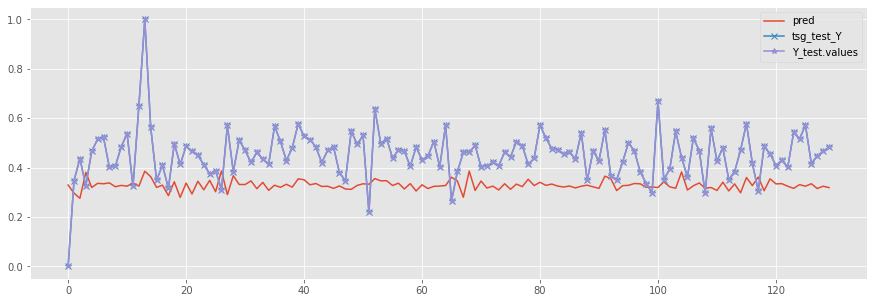

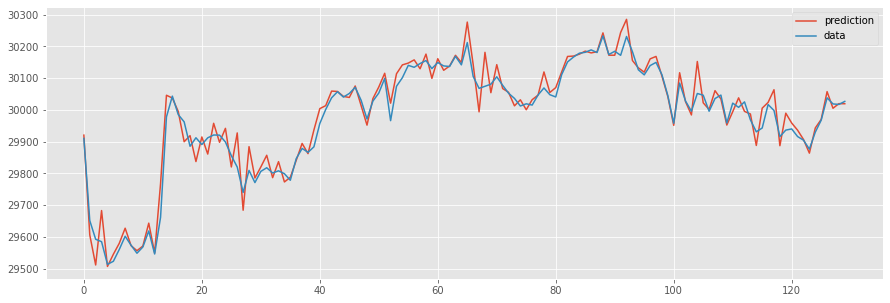

In [11]:
pred = model.predict(tsg_test, verbose=1, batch_size=1)

tsg_test_Y = []
for x in tsg_test:
    tsg_test_Y.extend(x[1][0])
#display(tsg_test_Y)

plt.plot(pred, label='pred')
plt.plot(tsg_test_Y, label='tsg_test_Y', linestyle='-', marker='x')
plt.plot(Y_test.values[cfg['train']['data']['tsg']['length']:], label='Y_test.values', marker='*')
plt.legend()
plt.show()

pred = inverse_normalize(pred, model_metadata['Y_train_scalers'])
#pred.set_index(Y_test.index[-pred.shape[0]:], inplace=True)
prev = data[cfg['train']['data']['Y']][-pred.shape[0]-cfg['prediction_steps']:-cfg['prediction_steps']]
pred = inverse_transform(pred, prev.values)
#pred.set_index(prev.index, inplace=True)
plt.plot(pred, label='prediction')
plt.plot(prev.values, label='data')
plt.legend()
plt.show()

In [171]:
data[cfg['train']['data']['Y']][-pred.shape[0]-1:-1].values

array([[29790.8203125 ],
       [29863.5703125 ],
       [29882.84960938],
       [29883.4296875 ],
       [29917.69921875],
       [29864.30078125],
       [29823.63085938],
       [29794.94921875],
       [29743.06054688],
       [29741.08984375],
       [29675.09960938],
       [29699.36914062],
       [29647.50976562],
       [29438.2890625 ],
       [29400.4296875 ],
       [29290.7890625 ],
       [29345.58984375],
       [29355.02929688],
       [29322.86914062],
       [29323.83984375],
       [29312.25976562],
       [29354.30078125],
       [29375.88085938],
       [29406.31054688],
       [29473.65039062],
       [29438.68945312],
       [29482.47070312],
       [29399.77929688],
       [29356.59960938],
       [29331.15039062],
       [29378.7890625 ],
       [29352.13085938],
       [29331.77929688],
       [29332.33007812],
       [29356.48046875],
       [29351.4609375 ],
       [29344.91015625],
       [29340.99023438],
       [29279.88085938],
       [29263.97070312],


129/129 [==============================] - 0s 3ms/step


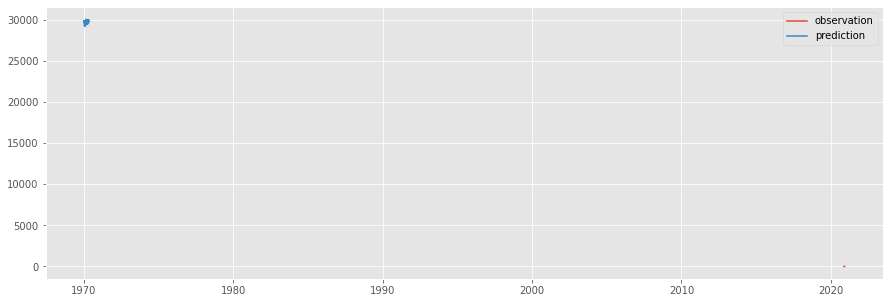

In [87]:
pred = model.predict(tsg_test, verbose=1, batch_size=1)
pred = inverse_normalize(pred, model_metadata['Y_test_scalers'])

# obs = inverse_normalize(Y_test.values, model_metadata['Y_test_scalers'])
# obs = obs[-pred.shape[0]:].reset_index(drop=True)

plt.plot(obs, label='observation')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [75]:
def transform(df, k=cfg['steps_ahead']):
    if cfg['differential'].lower() == 'true':
        if isinstance(df, pd.DataFrame):
            return df.diff(1, axis=0)[1:]
        else:
            return df[k:] - df[:-k]
    else:
        return df

def inverse_transform(pred, prev=None):
    if cfg['differential'].lower() == 'true':
        return prev + pred
    else:
        return pred

def normalize(df, scaler, fit=False, features=None):
    fn = scaler.fit_transform if fit else scaler.transform
    if isinstance(df, pd.DataFrame):
        if features is not None:
            df[features] = fn(df[features])
            return df
        else:
            index = df.index
            columns = df.columns
            df = pd.DataFrame(fn(df), index=index)
            df = df.set_axis(columns, axis=1)
            return fn(df)
    else:
        return fn(df)

def inverse_normalize(df, scaler, features):
    fn = scaler.inverse_transform
    if isinstance(df, pd.DataFrame):
        if features is not None:
            df[features] = fn(df[features].values)
            return df
        else:
            index = df.index
            columns = df.columns
            df = pd.DataFrame(fn(df), index=index)
            df = df.set_axis(columns, axis=1)
            return fn(df)
    else:
        return fn(df.values)

def get_tsg(
    df_x,
    df_y,
    length,
    batch_size
):
    return TimeseriesGenerator(
        df_x,
        df_y,
        length=length,
        sampling_rate=1,
        stride=1,
        batch_size=batch_size
    )

def tsg2tsv(tsg):
    ret = ''
    for i in range(len(tsg)):
        x, y = tsg[i]
        ret += '%s => %s\n' % (x, y)
    return ret

def predict(
    model,
    x,
    y,
    sequence_len=cfg['sequence_len'],
    batch_size=cfg['batch_size_test'],
    debug=False
):
    if debug:
        print('predict()')
        print_df(x, 'x')
        print_df(y, 'y')
        print('sequence_len', sequence_len)
    tsg = get_tsg(x, np.zeros(y.shape), length=sequence_len, batch_size=batch_size)
    print('len(tsg)', len(tsg))
    if debug:
        print(tsg2tsv(tsg))
    pred = model.predict(tsg, verbose=1, batch_size=batch_size)
    if debug:
        print_df(pred, 'pred')
    return pred

def train(
    df_train_x,
    df_train_y,
    model_name,
    sequence_len=cfg['sequence_len'],
    batch_size=cfg['batch_size_train'],
    epochs=cfg['num_epochs'],
    epochs_patience=cfg['epochs_patience'],
    debug=False
):
    tsg_train = get_tsg(df_train_x, df_train_y, length=sequence_len, batch_size=batch_size)
    if debug:
        print('tsg_train (3 steps):')
        for i in range(3):
            print('%s => %s' % (tsg_train[i]))
        
    n_features_x = df_train_x.shape[1]
    n_features_y = df_train_y.shape[1]
    print('n_features_x', n_features_x)
    print('n_features_y', n_features_y)

    # define model
    model = Sequential()
    model.add(
        LSTM(
            256,
            input_shape=(sequence_len, n_features_x),
            return_sequences=True,
        )
    )
    model.add(LSTM(128, activation='tanh', return_sequences=False))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(n_features_y))
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse', 'mae', 'mape']
    )
    model.summary()

    print('model.output_shape', model.output_shape)

    # Checkpointing and earlystopping
    filepath = os.path.join('./checkpoints', model_name + '-{epoch:02d}.hdf5')
    checkpoints = ModelCheckpoint(
        filepath,
        monitor='loss',
        save_best_only=True,
        mode='auto',
        verbose=1
    )
    #
    earlystops = EarlyStopping(
        monitor='loss',
        patience=epochs_patience,
        verbose=1
    )
    #
    callbacks_list = [checkpoints, earlystops]
    history = model.fit_generator(
        tsg_train,
        epochs=epochs,
        callbacks=callbacks_list,
        shuffle=False,
        verbose=1
    ).history
    
    # save model
    model_file = os.path.join('./models', model_name)
    model.save(model_file)
    joblib.dump(scaler, os.path.join('models', model_name, 'scaler_%s' % model_name))
    return model, history

def print_df(df, name):
    print('%s (len=%d):\n%s\n' % (name, len(df), df))

# split data to train and test
def split_data(data, ratio=0.67):
    train_size = int(len(data) * ratio)
    test_size = len(data) - train_size
    train = data[:train_size]
    test = data[-test_size:]
    return train, test

def data_and_targets(cols, data_features, target_features, df_train, df_test=None, debug=False):
    x_cols = []
    y_cols = []
    for idx_col in range(cols.size):
        col = cols[idx_col]
        if col in data_features:
            x_cols.append(idx_col)
        if col in target_features:
            y_cols.append(idx_col)
    if debug:
        print('data_and_targets()')
        print('cols', cols.values)
        print('x_cols', x_cols)
        print('y_cols', y_cols)
    return {
        'train_x': df_train[:,x_cols],
        'train_y': df_train[:,y_cols],
        'test_x': df_test[:,x_cols] if df_test is not None else None,
        'test_y': df_test[:,y_cols] if df_test is not None else None,
        'x_cols': x_cols,
        'y_cols': y_cols
    }

KeyError: 'steps_ahead'

In [53]:
normalized_features = ['open', 'high', 'low', 'close', 'volume']
data_features      = ['open', 'high', 'low', 'close', 'volume']
target_features    = ['close', 'volume']

models = {}

def plot_df(df, title=""):
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(12, 3*len(df.columns)), tight_layout=True)
    for i in range(len(df.columns)):
        col = df.columns[i]
        axs[i].plot(df[col])
        axs[i].set_title(("%s" + ("%s" if title == "" else " - %s")) % (col, title))
    plt.show()

for i in range(len(indexes)):
    
    index_name = indexes[i]
    df = frames[i]

    # transform
    df = transform(df)
    #plot_df(df, 'transformed')

    # resample
    #df_resampled = df.resample('3B').median()
    
    # --> draw plots for target features before and after resampling
    #     fig = None
    #     axs = []
    #     if len(target_features) > 1:
    #         fig, axs = plt.subplots(len(target_features), 1, figsize=(12, 6), tight_layout=True)
    #     else:
    #         axs = [plt]
    #     for j in range(len(target_features)):
    #         feature = target_features[j]
    #         axs[j].plot(df[feature], label='raw')
    #         axs[j].plot(df_resampled[feature], label='resampled')
    #         axs[j].set_title(feature) if isinstance(axs[j], plt.Subplot) else axs[j].title(feature)
    #         axs[j].legend()
    #     if len(axs) > 0:
    #         plt.show()
    # <--
    
    # continue on resampled data
    #df = df_resampled
    #plot_df(df, 'resampled')

    # split data to train and test
    df_train = df_test = None
    df_train, df_test = split_data(df)
    
    # normalize with fit on train 
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train = normalize(df_train, scaler, fit=True,  features=normalized_features)
    df_test  = normalize(df_test,  scaler, fit=False, features=normalized_features)
    
    # get data and targets
    df_train_x = df_train[data_features]
    df_train_y = df_train[target_features]
    df_test_x = df_test[data_features]
    df_test_y = df_test[target_features]

    # draw plots for x
    fig, axs = plt.subplots(len(df_train_x.columns), 1, figsize=(24, 3*len(df_train_x.columns)), tight_layout=True)
    for j in range(len(df_train_x.columns)):
        col = df_train_x.columns[j]
        axs[j].plot(df_train_x[col], color='C0', label='train')
        axs[j].plot(df_test_x[col], color='C1', label='test')
        axs[j].set_title('X - %s' % col)
        axs[j].legend()
    plt.show()

    # draw plots for y
    fig, axs = plt.subplots(len(df_train_y.columns), 1, figsize=(24, 3*len(df_train_y.columns)), tight_layout=True)
    for j in range(len(df_train_y.columns)):
        col = df_train_y.columns[j]
        axs[j].plot(df_train_y[col], color='C0', label='train')
        axs[j].plot(df_test_y[col], color='C1', label='test')
        axs[j].set_title('Y - %s' % col)
        axs[j].legend()
    plt.show()
    
    # train model
    model_name = '%s_s%02d_k%02d' % (index_name, cfg['sequence_len'], cfg['steps_ahead'])
    model, history = train(
        df_train_x.values,
        df_train_y.values,
        model_name,
        debug=False
    )
    
    plt.plot(history['loss'])
    plt.show()
    
    models[index] = {
        'df_train_x': df_train_x,
        'df_train_y': df_train_y,
        'df_test_x': df_test_x,
        'df_test_y': df_test_y,
        'model': model,
        'history': history,
        'scaler': scaler,
        'normalized_features': normalized_features,
        'data_features': data_features,
        'target_features': target_features
    }

NameError: name 'indexes' is not defined

In [4]:
debug = False
for k,v in models.items():
    
    index_name = indexes.index(k)
    
    df_orig = frames[index_name]
    df_orig_test = df_orig

    y_pred = None
    y_true = None
    
    model = v['model']
    data_features = v['data_features']
    target_features = v['target_features']
    
    df_orig_test_x = df_orig_test[data_features]
    df_orig_test_y = df_orig_test[target_features]

    if debug:
        print('df_orig_test_x', df_orig_test_x)
    if debug:
        print('df_orig_test_y', df_orig_test_y)
    
    for step in range(len(df_orig_test_x)-cfg['sequence_len']-2*cfg['steps_ahead']):
        x = df_orig_test_x[step:step+cfg['sequence_len']+cfg['steps_ahead']]
        if debug:
            print('x', x)
        yp = df_orig_test[step+cfg['sequence_len']:step+cfg['sequence_len']+1]
        yp = yp[v['target_features']]
        if debug:
            print('yp', yp)
        y = df_orig_test[step+cfg['sequence_len']+cfg['steps_ahead']:step+cfg['sequence_len']+cfg['steps_ahead']+1]
        y = y[v['target_features']]
        if debug:
            print('y', y)
        # transform
        x = transform(x)
        if debug:
            print('x', x)
        # normalize
        xt = normalize(x, v['scaler'], fit=False, features=v['normalized_features'])
        xt = xt[v['data_features']]
        if debug:
            print('xt', xt)
        if len(xt) != cfg['sequence_len']:
            print('ERROR')
            print('xt', xt)
            break
        # predict
        p = model.predict(xt.values[np.newaxis])
        p = pd.DataFrame(p, y.index)
        p.set_axis(y.columns, axis=1, inplace=True)
        if debug:
            print('p', p)
        # inverse normalize
        dummy = pd.DataFrame(np.zeros(shape=(1, df_orig_test.shape[1])), index=y.index)
        dummy.set_axis(df_orig_test.columns, axis=1, inplace=True)
        dummy[v['target_features']] = p
        if debug:
            print('dummy', dummy)
        dummyt = inverse_normalize(dummy, v['scaler'], v['normalized_features'])
        dummyt = dummyt[v['target_features']]
        if debug:
            print('dummyt', dummyt)
        # inverse transform
        pred = inverse_transform(dummyt, prev=yp.values)
        if debug:
            print('pred', pred)
        if y_pred is None:
            y_pred = pred
        else:
            y_pred = pd.concat([y_pred, pred], axis=0)
        if debug:
            print('y_pred', y_pred)
        if y_true is None:
            y_true = y
        else:
            y_true = pd.concat([y_true, y], axis=0)
        if debug:
            print('y_true', y_true)
    v['y_pred'] = y_pred
    v['y_true'] = y_true

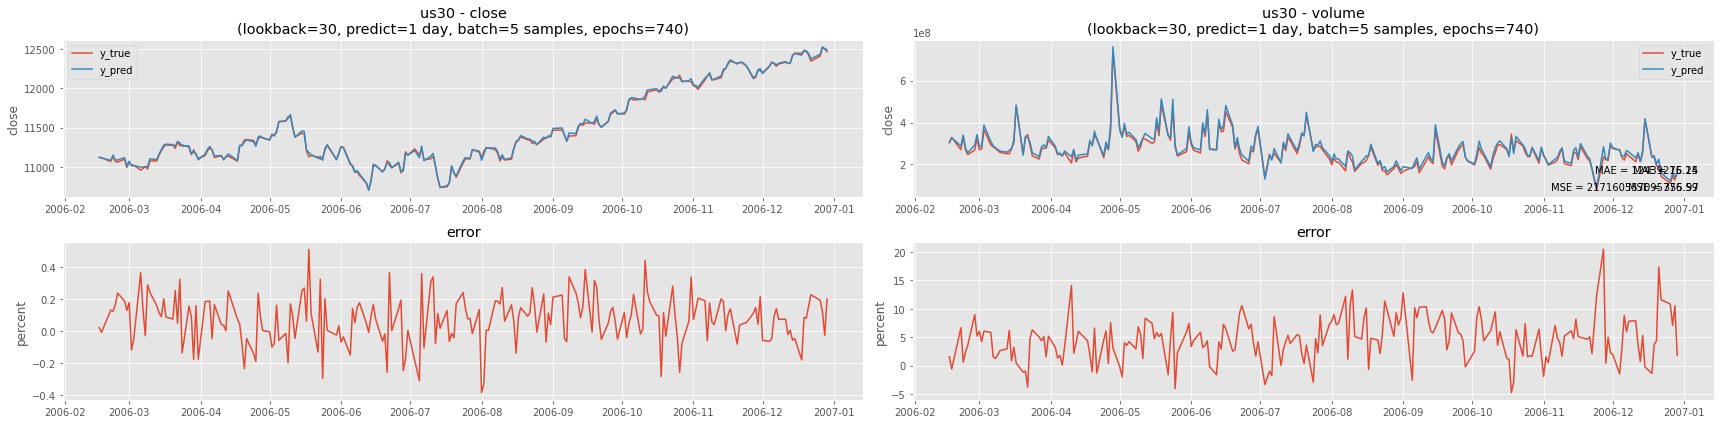

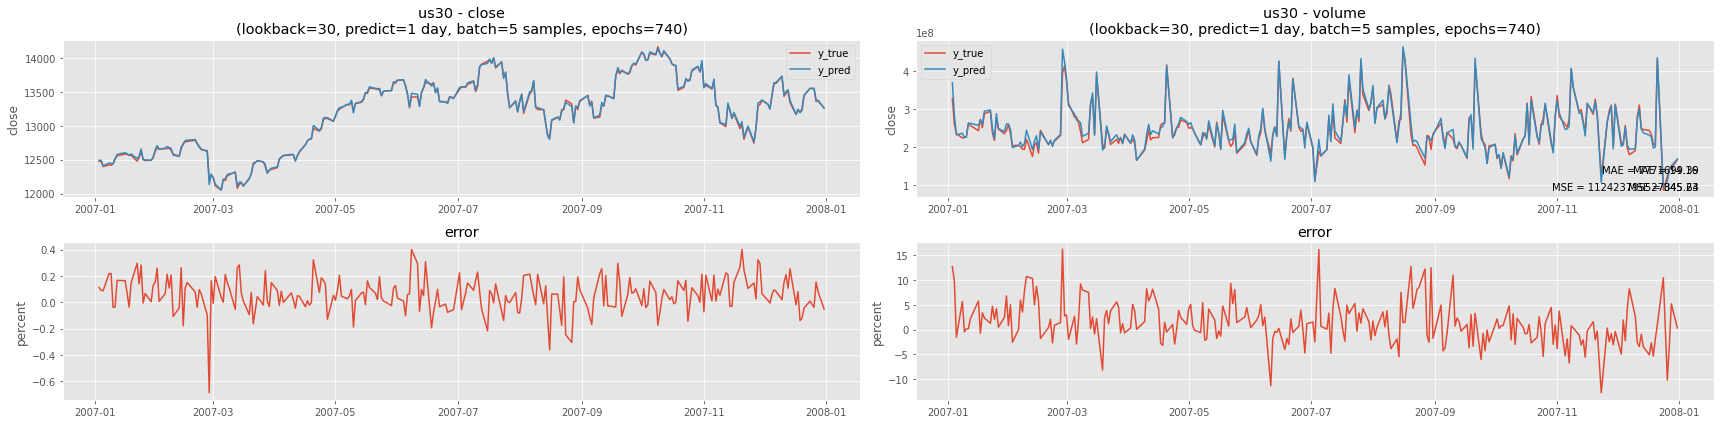

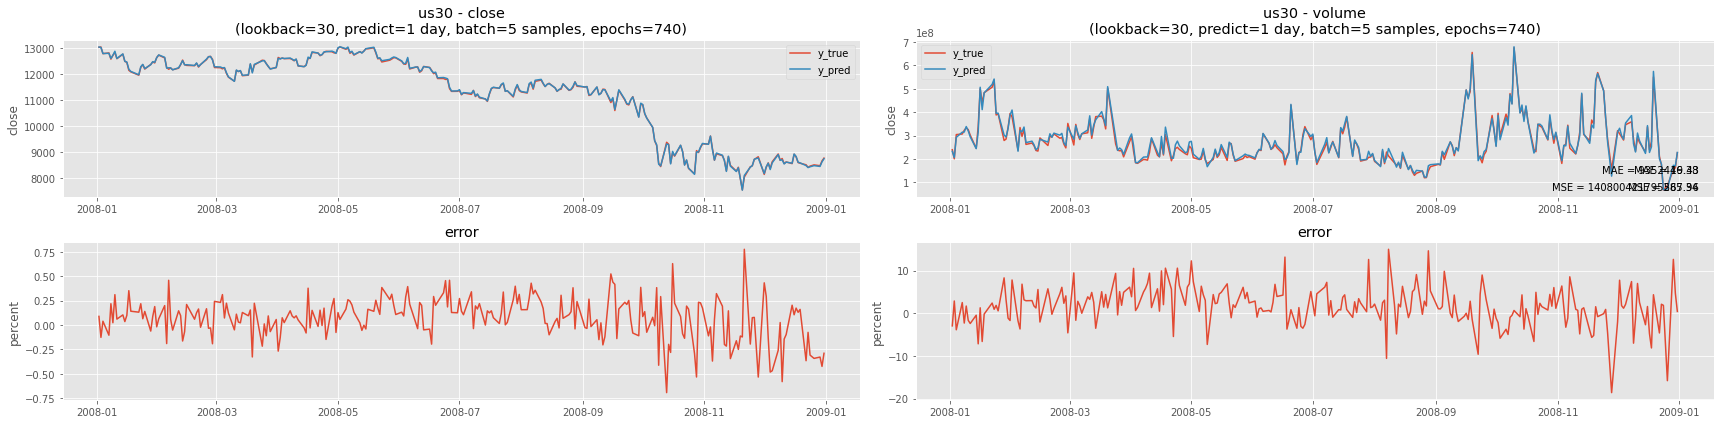

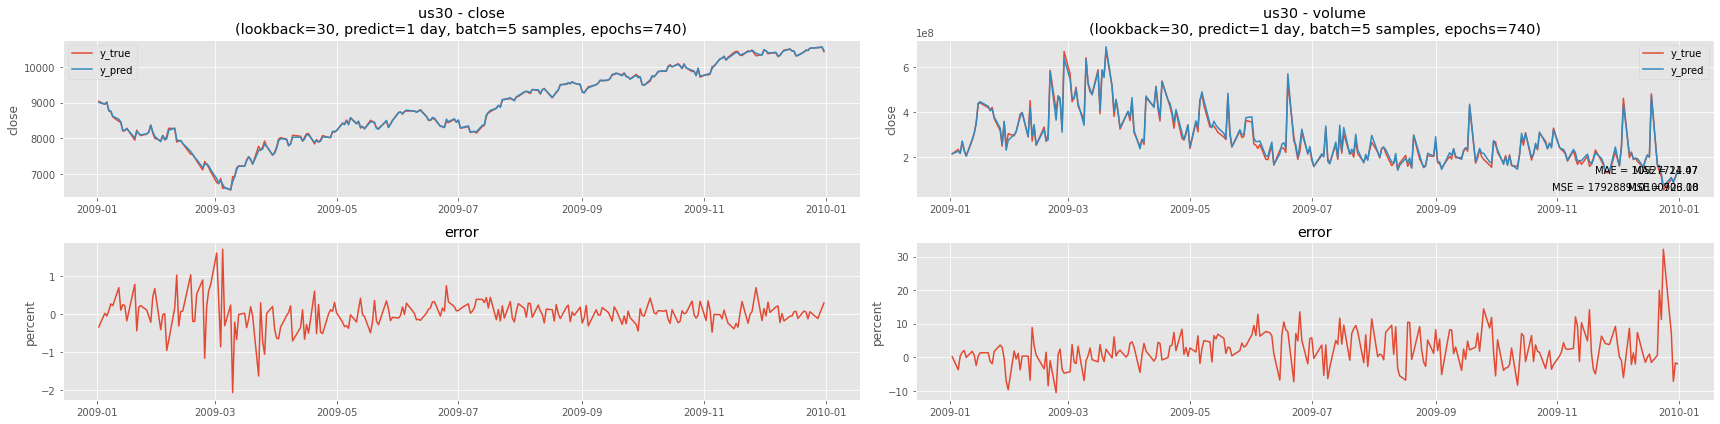

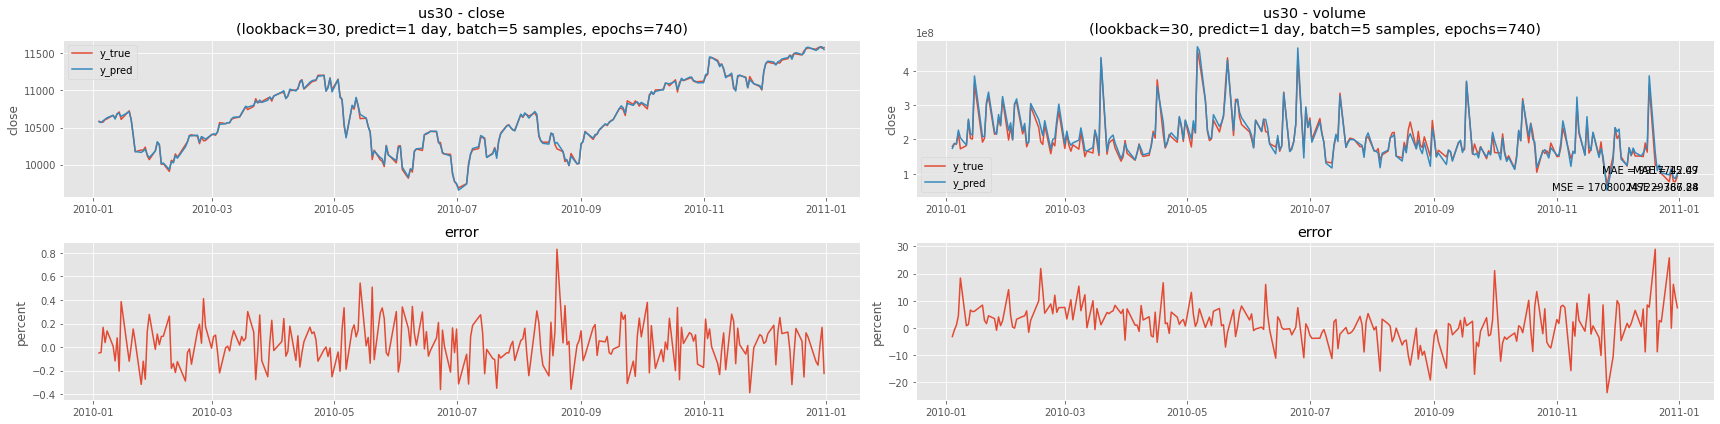

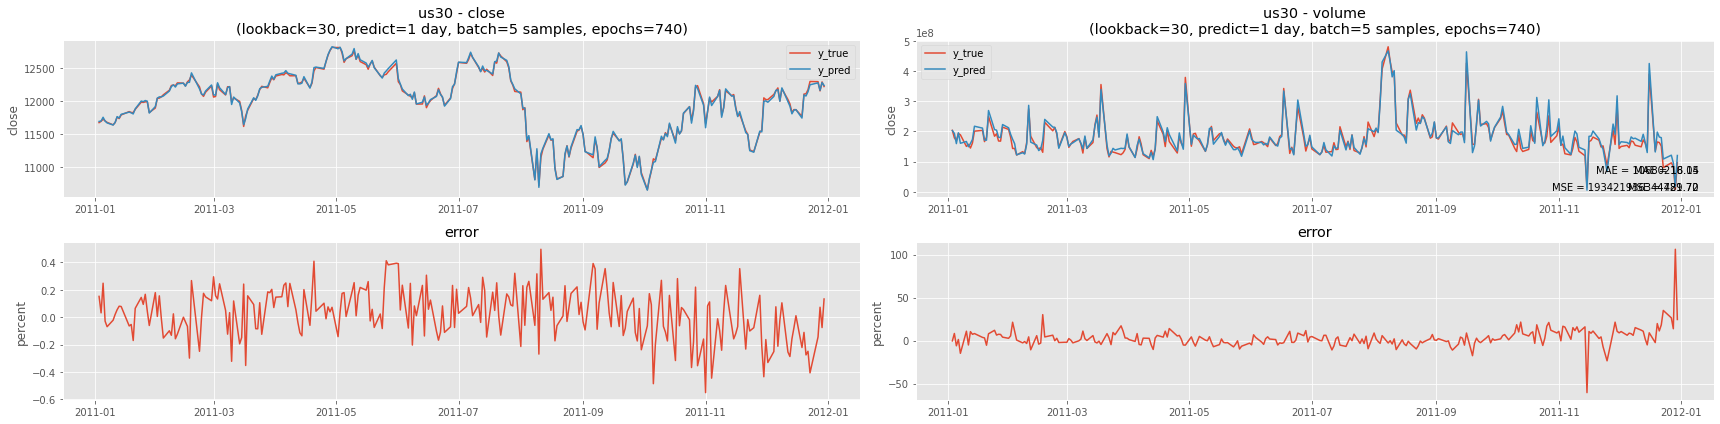

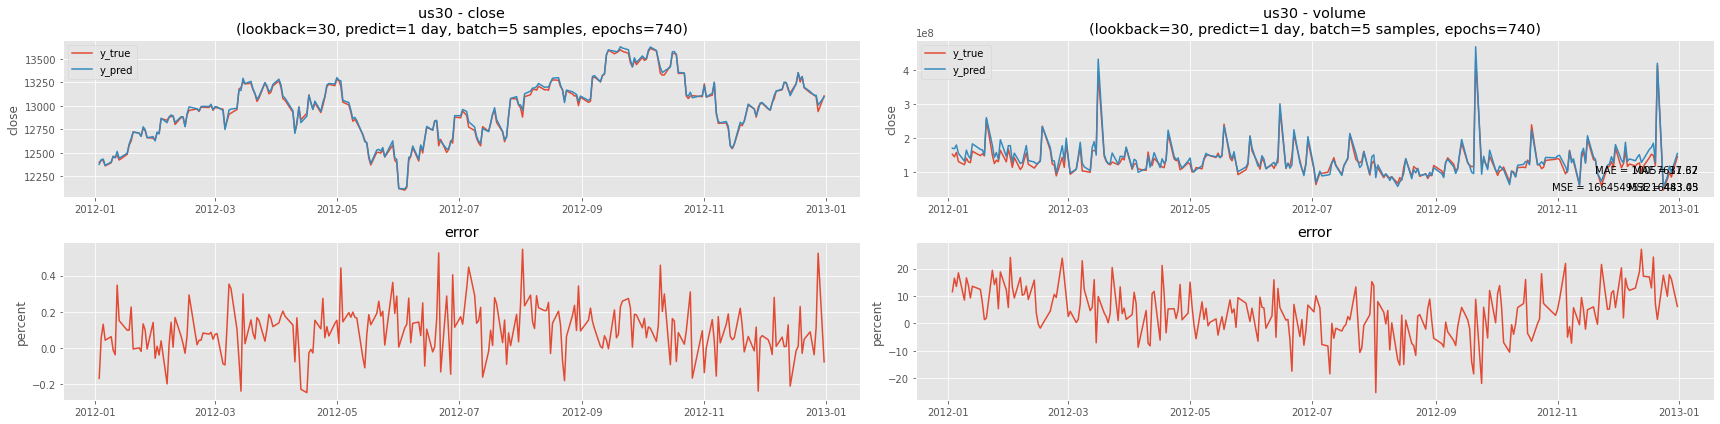

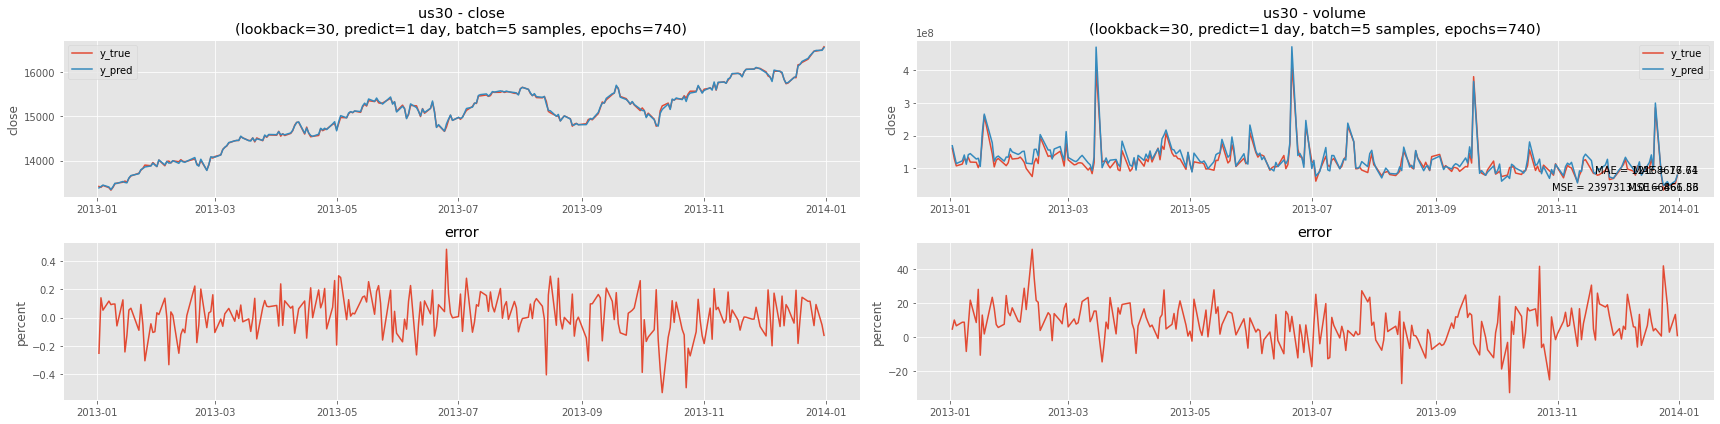

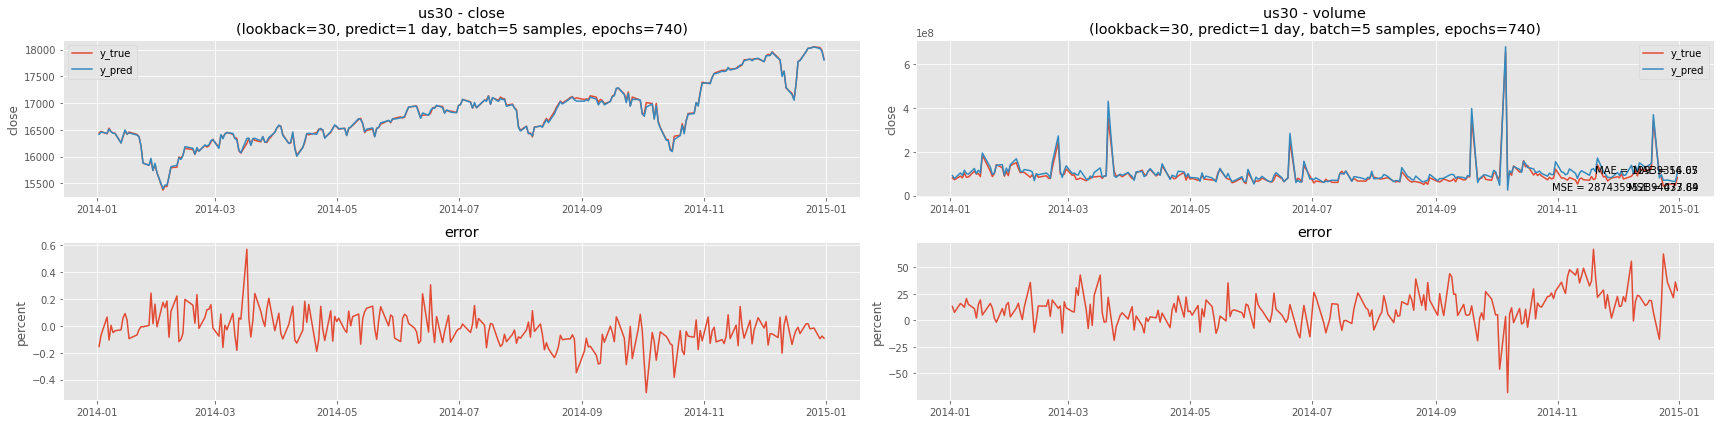

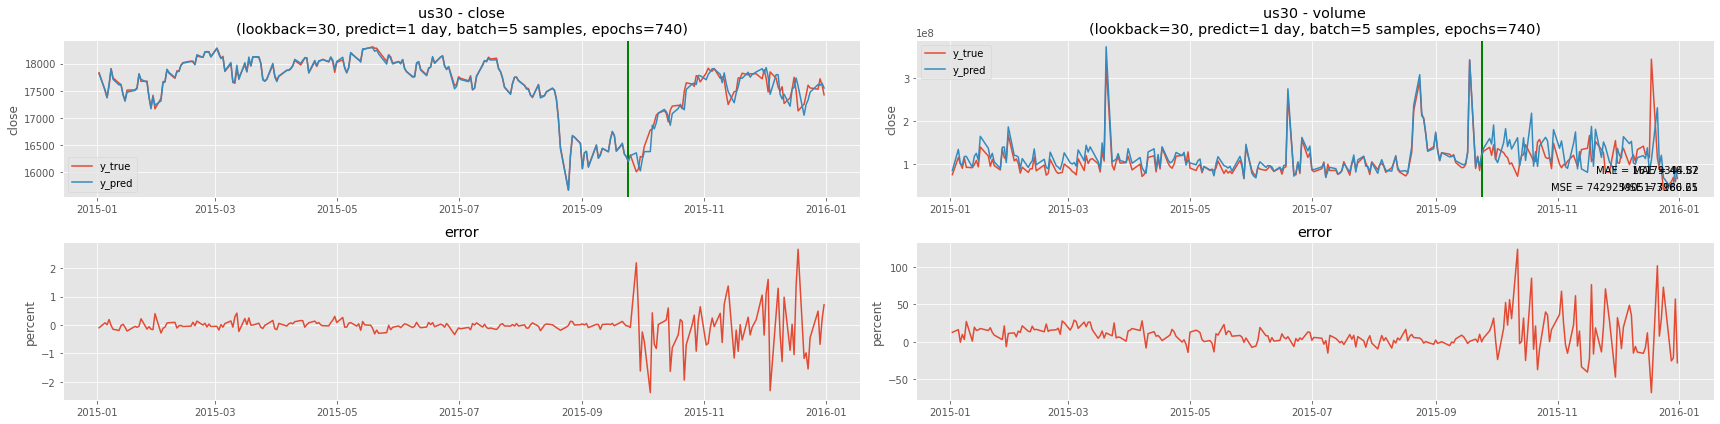

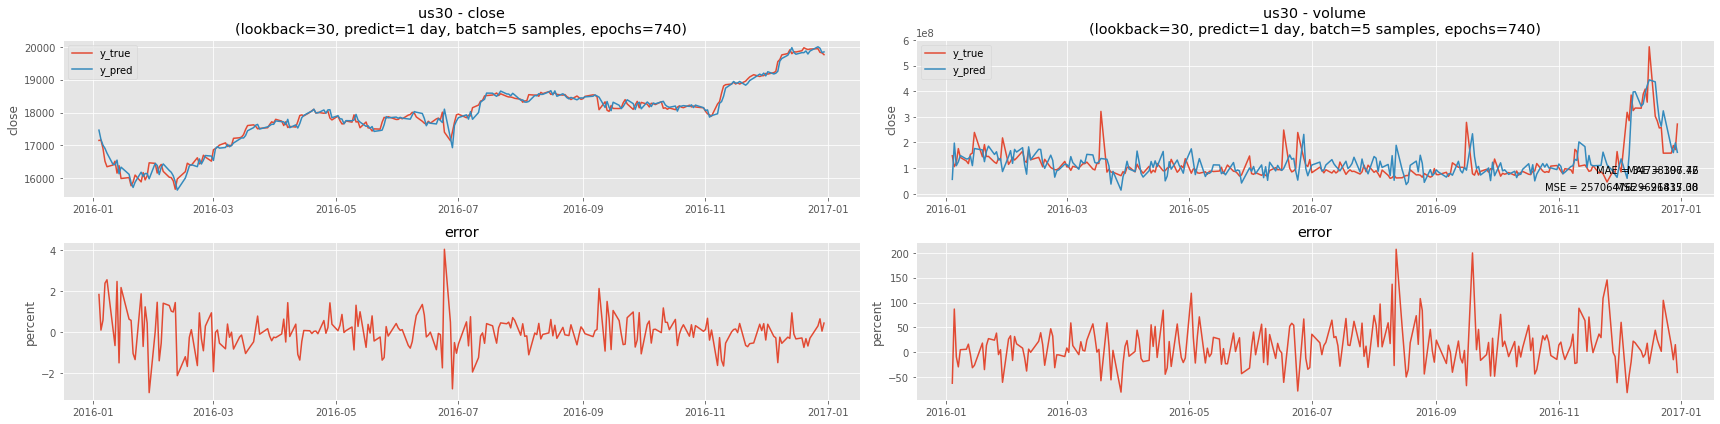

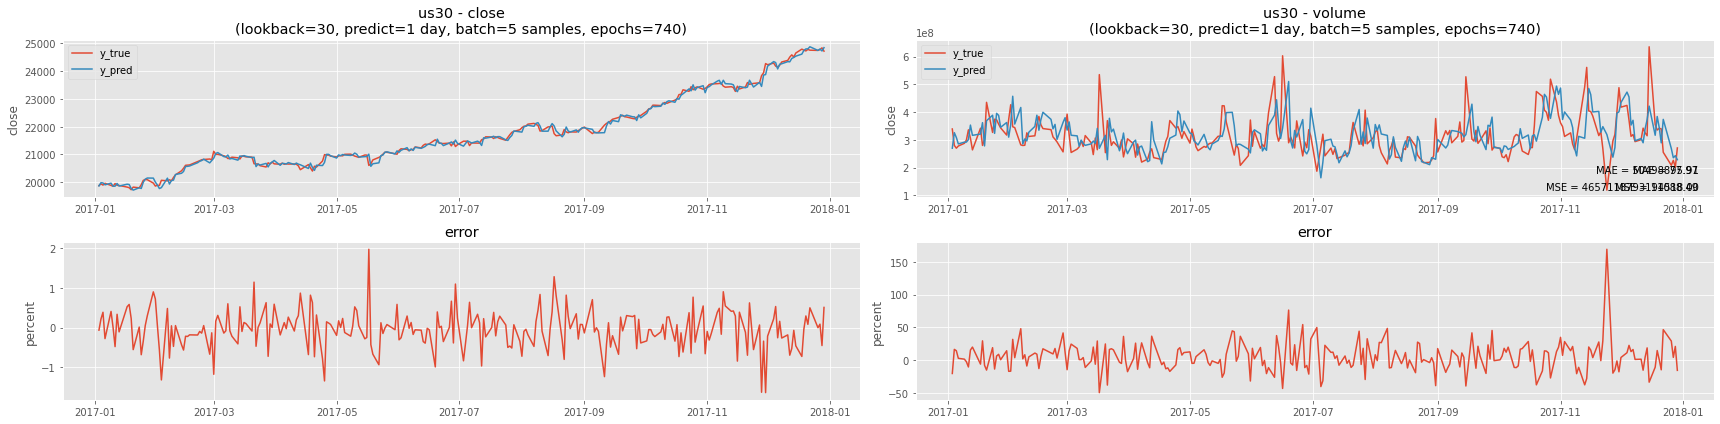

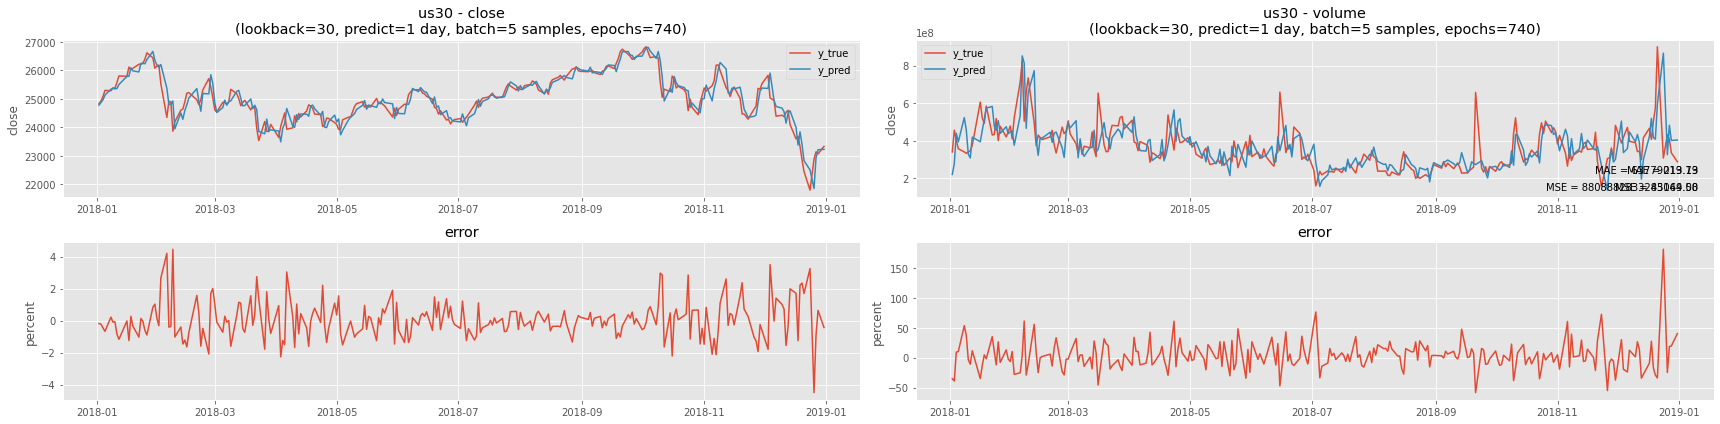

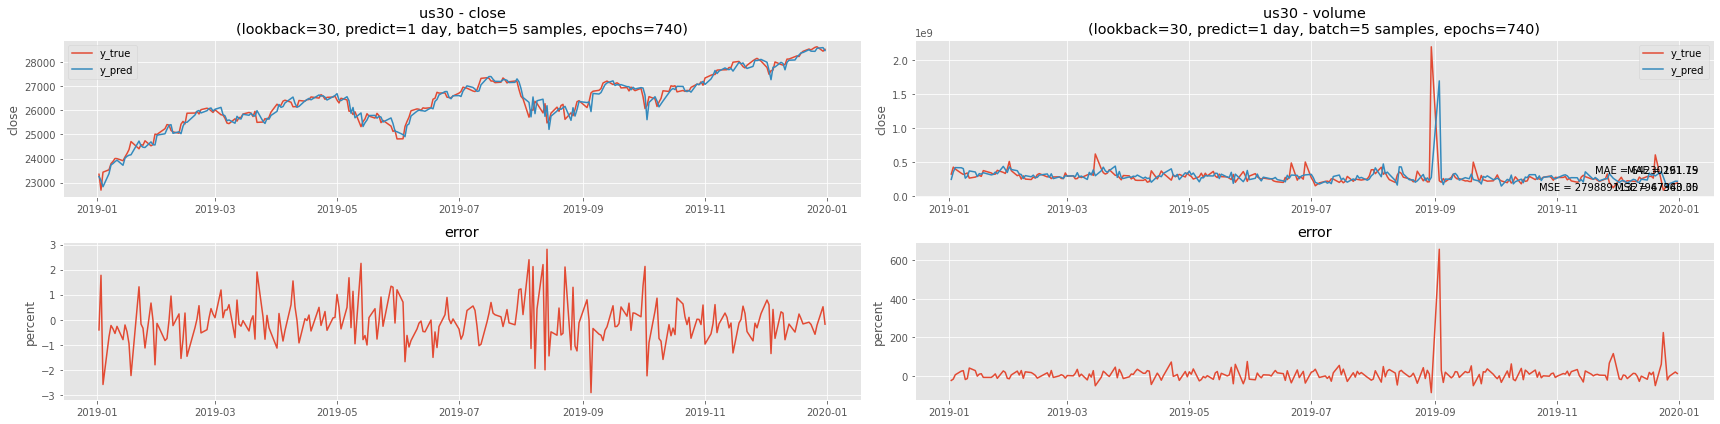

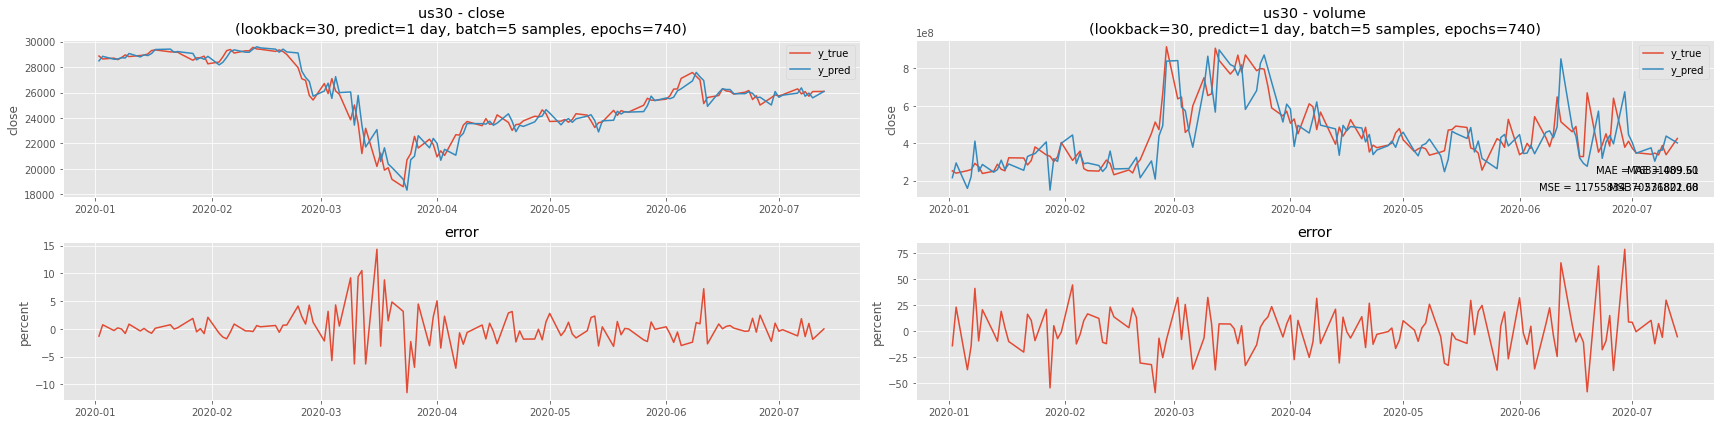

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
matplotlib.rcParams['text.usetex'] = False

for k,v in models.items():
    for year in range(2006,2021):
        #y_pred = y_pred[(y_pred.index >= pd.Timestamp('%d-01' % year)) & (y_pred.index <= pd.Timestamp('%d-02' % year))]
        y_pred = v['y_pred'][(v['y_pred'].index.year == year)]
        y_true = v['y_true'][v['y_true'].index.isin(y_pred.index)]
        fig, axs = plt.subplots(2, len(y_pred.columns), figsize=(24, 3*len(y_pred.columns)), tight_layout=True)
        for i in range(len(y_pred.columns)):
            col = y_pred.columns[i]
            axs[0][i].set_title('%s - %s\n(lookback=%d, predict=%d day, batch=%d samples, epochs=740)' % (k, col, cfg['sequence_len'], cfg['steps_ahead'], cfg['batch_size_train']))
            axs[0][i].plot(y_true[col], label='y_true')
            train_test = frames[indexes.index(k)][:len(v['df_train_x'])][-1:].index[0]
            if train_test in y_pred.index:
                axs[0][i].axvline(train_test, linewidth=2, color='green')
            axs[0][i].plot(y_pred[col], label='y_pred')
            axs[0][i].set_ylabel('close')
            axs[0][i].legend()
            MSE = mean_squared_error(y_true = y_true[col], y_pred = y_pred[col])
            MAE = mean_absolute_error(y_true = y_true[col], y_pred = y_pred[col])
            plt.figtext(0.985, 0.55, 'MSE = %.2f' % MSE, fontdict={'horizontalalignment':'right'})
            plt.figtext(0.985, 0.59, 'MAE = %.2f' % MAE, fontdict={'horizontalalignment':'right'})
            axs[1][i].plot(100.0*((y_pred[col]-y_true[col])/y_true[col]))
            axs[1][i].set_title('error')
            axs[1][i].set_ylabel('percent')
        plt.savefig(os.path.join('./images','%s_close_%d_l%d_k%d_b%d_e%d-%d' % (k, year, cfg['sequence_len'], cfg['steps_ahead'], cfg['batch_size_train'], 740, cfg['num_epochs'])))
        plt.show()

In [6]:
for k,v in models.items():
    index_name = indexes.index(k)
    df_orig = frames[index_name]
    df_orig_test = df_orig
    df_orig_test_x = df_orig[v['data_features']]
    df_orig_test_y = df_orig[v['target_features']]
    print(v['model'].predict(df_orig_test_x.values[np.newaxis]))
    y_pred = df_orig_test_x[cfg['sequence_len']+1:] + v['model'].predict(df_orig_test_x.values)
    y_true = df_orig_test_y[cfg['sequence_len']+cfg['steps_ahead']+1:]
    plt.plot(y_pred)

[[0.26470447 0.28016567]]


ValueError: in user code:

    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/stevo/.pyenv/versions/3.8.6/envs/burza/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 5]
